# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 uncertainty-adjusted topics most highly correlated with Consumption growth (out of 200 topics estimated on articles published before 2008 using all sources). I forecast Consumption growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 uncertainty-adjusted topics (<=2007, 200 topics, all sources).
- **Forecast Target:** Consumption growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Hard+Surveys Factors:** 1 to 2
  - **Number of Text Factors:** 1
  - **Factor Order:** 1 to 3

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function_update

# Define inputs common to all models
q_var = 'Consumption'                     # quarterly variable being forecasted
additional_factors = 'HardSurveys+Text'   # switch to separate factors scenario
start = '1991-04'
text_type = "topics_uncertainty"
estimation_period = "2007"
num_topics = "200"
source = "all"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual_update.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of HardSurveys factors (1 or 2) and factor order values from 1 to 3
for num_factors in range(1, 3):  # 1 or 2 HardSurveys factors
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'HardSurveys': num_factors, 'Text': 1}
        factor_orders = {'HardSurveys': order, 'Text': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function_update.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function_update.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with HardSurveys factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = f"HS_{num_factors}_{order}"
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11944
EM iteration 100, llf=-11680, convergence criterion=2.4826e-06
EM converged at iteration 174, llf=-11679, convergence criterion=9.9968e-07 < tolerance=1e-06
EM start iterations, llf=-11956
EM iteration 100, llf=-11693, convergence criterion=2.48e-06
EM converged at iteration 174, llf=-11691, convergence criterion=9.9863e-07 < tolerance=1e-06
EM start iterations, llf=-12011
EM iteration 100, llf=-11744, convergence criterion=2.4432e-06
EM converged at iteration 173, llf=-11743, convergence criterion=9.9172e-07 < tolerance=1e-06
EM start iterations, llf=-12017
EM iteration 100, llf=-11751, convergence criterion=2.4418e-06
EM converged at iteration 173, llf=-11750, convergence criterion=9.9112e-07 < tolerance=1e-06
EM start iterations, llf=-12081
EM iteration 100, llf=-11809, convergence criterion=2.511e-06
EM converged at iteration 176, llf=-11808, convergence criterion=9.9665e-07 < tolerance=1e-06
EM start iterations, llf=-12089
EM iteration 100, llf=-118

EM converged at iteration 135, llf=-12804, convergence criterion=9.9641e-07 < tolerance=1e-06
EM start iterations, llf=-13082
EM iteration 100, llf=-12852, convergence criterion=1.9136e-06
EM converged at iteration 135, llf=-12851, convergence criterion=9.9505e-07 < tolerance=1e-06
EM start iterations, llf=-13089
EM iteration 100, llf=-12859, convergence criterion=1.9124e-06
EM converged at iteration 135, llf=-12858, convergence criterion=9.9441e-07 < tolerance=1e-06
EM start iterations, llf=-13132
EM iteration 100, llf=-12896, convergence criterion=1.9066e-06
EM converged at iteration 135, llf=-12896, convergence criterion=9.8537e-07 < tolerance=1e-06
EM start iterations, llf=-13142
EM iteration 100, llf=-12906, convergence criterion=1.9058e-06
EM converged at iteration 135, llf=-12906, convergence criterion=9.8489e-07 < tolerance=1e-06
EM start iterations, llf=-13204
EM iteration 100, llf=-12974, convergence criterion=1.8265e-06
EM converged at iteration 132, llf=-12974, convergence 

EM start iterations, llf=-14265
EM iteration 100, llf=-14044, convergence criterion=1.7325e-06
EM converged at iteration 127, llf=-14043, convergence criterion=9.9452e-07 < tolerance=1e-06
EM start iterations, llf=-14304
EM iteration 100, llf=-14076, convergence criterion=1.8646e-06
EM converged at iteration 130, llf=-14075, convergence criterion=9.9913e-07 < tolerance=1e-06
EM start iterations, llf=-14310
EM iteration 100, llf=-14088, convergence criterion=1.8585e-06
EM converged at iteration 130, llf=-14087, convergence criterion=9.9642e-07 < tolerance=1e-06
EM start iterations, llf=-14360
EM iteration 100, llf=-14145, convergence criterion=1.583e-06
EM converged at iteration 123, llf=-14144, convergence criterion=9.9232e-07 < tolerance=1e-06
EM start iterations, llf=-14360
EM iteration 100, llf=-14145, convergence criterion=1.583e-06
EM converged at iteration 123, llf=-14144, convergence criterion=9.9232e-07 < tolerance=1e-06
EM start iterations, llf=-14371
EM iteration 100, llf=-14

EM start iterations, llf=-15695
EM converged at iteration 81, llf=-15467, convergence criterion=9.8951e-07 < tolerance=1e-06
EM start iterations, llf=-15703
EM converged at iteration 81, llf=-15475, convergence criterion=9.8853e-07 < tolerance=1e-06
EM start iterations, llf=-15765
EM converged at iteration 82, llf=-15532, convergence criterion=9.8169e-07 < tolerance=1e-06
EM start iterations, llf=-15777
EM converged at iteration 82, llf=-15545, convergence criterion=9.8186e-07 < tolerance=1e-06
EM start iterations, llf=-15833
EM converged at iteration 85, llf=-15600, convergence criterion=9.7799e-07 < tolerance=1e-06
EM start iterations, llf=-15833
EM converged at iteration 85, llf=-15600, convergence criterion=9.7799e-07 < tolerance=1e-06
EM start iterations, llf=-15844
EM converged at iteration 85, llf=-15612, convergence criterion=9.7716e-07 < tolerance=1e-06
EM start iterations, llf=-15897
EM converged at iteration 73, llf=-15664, convergence criterion=9.9127e-07 < tolerance=1e-06


EM start iterations, llf=-17440
EM converged at iteration 67, llf=-17184, convergence criterion=9.7319e-07 < tolerance=1e-06
EM start iterations, llf=-17497
EM converged at iteration 67, llf=-17243, convergence criterion=9.7393e-07 < tolerance=1e-06
EM start iterations, llf=-17497
EM converged at iteration 67, llf=-17243, convergence criterion=9.7393e-07 < tolerance=1e-06
EM start iterations, llf=-17506
EM converged at iteration 67, llf=-17253, convergence criterion=9.7264e-07 < tolerance=1e-06
EM start iterations, llf=-17560
EM converged at iteration 66, llf=-17307, convergence criterion=9.8709e-07 < tolerance=1e-06
EM start iterations, llf=-17566
EM converged at iteration 66, llf=-17314, convergence criterion=9.8623e-07 < tolerance=1e-06
EM start iterations, llf=-17618
EM converged at iteration 67, llf=-17364, convergence criterion=9.7769e-07 < tolerance=1e-06
EM start iterations, llf=-17627
EM converged at iteration 67, llf=-17373, convergence criterion=9.7711e-07 < tolerance=1e-06


EM start iterations, llf=-18954
EM converged at iteration 63, llf=-18678, convergence criterion=9.681e-07 < tolerance=1e-06
EM start iterations, llf=-19010
EM converged at iteration 63, llf=-18736, convergence criterion=9.8841e-07 < tolerance=1e-06
EM start iterations, llf=-19015
EM converged at iteration 63, llf=-18739, convergence criterion=9.884e-07 < tolerance=1e-06
EM start iterations, llf=-19068
EM converged at iteration 64, llf=-18790, convergence criterion=9.9073e-07 < tolerance=1e-06
EM start iterations, llf=-19079
EM converged at iteration 64, llf=-18800, convergence criterion=9.8997e-07 < tolerance=1e-06
EM start iterations, llf=-19128
EM converged at iteration 64, llf=-18849, convergence criterion=9.8556e-07 < tolerance=1e-06
EM start iterations, llf=-19128
EM converged at iteration 64, llf=-18849, convergence criterion=9.8556e-07 < tolerance=1e-06
EM start iterations, llf=-19139
EM converged at iteration 64, llf=-18860, convergence criterion=9.8464e-07 < tolerance=1e-06
EM

EM start iterations, llf=-12708
EM converged at iteration 84, llf=-12474, convergence criterion=9.8695e-07 < tolerance=1e-06
EM start iterations, llf=-12765
EM converged at iteration 84, llf=-12541, convergence criterion=9.7851e-07 < tolerance=1e-06
EM start iterations, llf=-12800
EM converged at iteration 83, llf=-12579, convergence criterion=9.9351e-07 < tolerance=1e-06
EM start iterations, llf=-12841
EM converged at iteration 83, llf=-12619, convergence criterion=9.9247e-07 < tolerance=1e-06
EM start iterations, llf=-12841
EM converged at iteration 83, llf=-12619, convergence criterion=9.9247e-07 < tolerance=1e-06
EM start iterations, llf=-12848
EM converged at iteration 83, llf=-12618, convergence criterion=9.8646e-07 < tolerance=1e-06
EM start iterations, llf=-12899
EM converged at iteration 83, llf=-12665, convergence criterion=9.9008e-07 < tolerance=1e-06
EM start iterations, llf=-12907
EM converged at iteration 83, llf=-12669, convergence criterion=9.8738e-07 < tolerance=1e-06


EM start iterations, llf=-14548
EM converged at iteration 84, llf=-14318, convergence criterion=9.8856e-07 < tolerance=1e-06
EM start iterations, llf=-14548
EM converged at iteration 84, llf=-14318, convergence criterion=9.8856e-07 < tolerance=1e-06
EM start iterations, llf=-14558
EM converged at iteration 84, llf=-14327, convergence criterion=9.8635e-07 < tolerance=1e-06
EM start iterations, llf=-14603
EM converged at iteration 85, llf=-14371, convergence criterion=9.8565e-07 < tolerance=1e-06
EM start iterations, llf=-14615
EM converged at iteration 85, llf=-14385, convergence criterion=9.9709e-07 < tolerance=1e-06
EM start iterations, llf=-14656
EM converged at iteration 84, llf=-14426, convergence criterion=9.9633e-07 < tolerance=1e-06
EM start iterations, llf=-14665
EM converged at iteration 84, llf=-14431, convergence criterion=9.9985e-07 < tolerance=1e-06
EM start iterations, llf=-14709
EM converged at iteration 82, llf=-14471, convergence criterion=9.7702e-07 < tolerance=1e-06


EM start iterations, llf=-15840
EM converged at iteration 81, llf=-15579, convergence criterion=9.828e-07 < tolerance=1e-06
EM start iterations, llf=-15848
EM converged at iteration 81, llf=-15588, convergence criterion=9.8267e-07 < tolerance=1e-06
EM start iterations, llf=-16326
EM converged at iteration 82, llf=-16077, convergence criterion=9.8687e-07 < tolerance=1e-06
EM start iterations, llf=-16331
EM converged at iteration 82, llf=-16082, convergence criterion=9.9007e-07 < tolerance=1e-06
EM start iterations, llf=-16378
EM converged at iteration 81, llf=-16130, convergence criterion=9.8445e-07 < tolerance=1e-06
EM start iterations, llf=-16378
EM converged at iteration 81, llf=-16130, convergence criterion=9.8445e-07 < tolerance=1e-06
EM start iterations, llf=-16391
EM converged at iteration 81, llf=-16143, convergence criterion=9.8483e-07 < tolerance=1e-06
EM start iterations, llf=-16448
EM converged at iteration 81, llf=-16202, convergence criterion=9.8169e-07 < tolerance=1e-06
E

EM start iterations, llf=-17997
EM converged at iteration 86, llf=-17735, convergence criterion=9.9934e-07 < tolerance=1e-06
EM start iterations, llf=-18054
EM converged at iteration 88, llf=-17791, convergence criterion=9.9679e-07 < tolerance=1e-06
EM start iterations, llf=-18054
EM converged at iteration 88, llf=-17791, convergence criterion=9.9679e-07 < tolerance=1e-06
EM start iterations, llf=-18064
EM converged at iteration 88, llf=-17803, convergence criterion=9.9869e-07 < tolerance=1e-06
EM start iterations, llf=-18115
EM converged at iteration 84, llf=-17852, convergence criterion=9.9552e-07 < tolerance=1e-06
EM start iterations, llf=-18122
EM converged at iteration 84, llf=-17858, convergence criterion=9.944e-07 < tolerance=1e-06
EM start iterations, llf=-18179
EM converged at iteration 87, llf=-17913, convergence criterion=9.9726e-07 < tolerance=1e-06
EM start iterations, llf=-18186
EM converged at iteration 87, llf=-17921, convergence criterion=9.972e-07 < tolerance=1e-06
EM

EM start iterations, llf=-19497
EM converged at iteration 67, llf=-19212, convergence criterion=9.8215e-07 < tolerance=1e-06
EM start iterations, llf=-19503
EM converged at iteration 67, llf=-19221, convergence criterion=9.8373e-07 < tolerance=1e-06
EM start iterations, llf=-19561
EM converged at iteration 67, llf=-19279, convergence criterion=9.907e-07 < tolerance=1e-06
EM start iterations, llf=-19569
EM converged at iteration 67, llf=-19286, convergence criterion=9.9032e-07 < tolerance=1e-06
EM start iterations, llf=-19624
EM converged at iteration 68, llf=-19340, convergence criterion=9.9946e-07 < tolerance=1e-06
EM start iterations, llf=-19630
EM converged at iteration 68, llf=-19346, convergence criterion=9.9862e-07 < tolerance=1e-06
EM start iterations, llf=-19679
EM converged at iteration 71, llf=-19392, convergence criterion=9.8642e-07 < tolerance=1e-06
EM start iterations, llf=-19679
EM converged at iteration 71, llf=-19392, convergence criterion=9.8642e-07 < tolerance=1e-06
E

EM start iterations, llf=-12826
EM iteration 100, llf=-12612, convergence criterion=1.5285e-06
EM converged at iteration 127, llf=-12611, convergence criterion=9.9299e-07 < tolerance=1e-06
EM start iterations, llf=-12826
EM iteration 100, llf=-12612, convergence criterion=1.5285e-06
EM converged at iteration 127, llf=-12611, convergence criterion=9.9299e-07 < tolerance=1e-06
EM start iterations, llf=-12834
EM iteration 100, llf=-12610, convergence criterion=1.5162e-06
EM converged at iteration 126, llf=-12609, convergence criterion=9.9953e-07 < tolerance=1e-06
EM start iterations, llf=-12886
EM iteration 100, llf=-12657, convergence criterion=1.5857e-06
EM converged at iteration 130, llf=-12656, convergence criterion=9.9464e-07 < tolerance=1e-06
EM start iterations, llf=-12895
EM iteration 100, llf=-12661, convergence criterion=1.5809e-06
EM converged at iteration 130, llf=-12660, convergence criterion=9.9195e-07 < tolerance=1e-06
EM start iterations, llf=-12951
EM iteration 100, llf=-

EM converged at iteration 109, llf=-13790, convergence criterion=9.9411e-07 < tolerance=1e-06
EM start iterations, llf=-14017
EM iteration 100, llf=-13805, convergence criterion=1.1727e-06
EM converged at iteration 110, llf=-13805, convergence criterion=9.8493e-07 < tolerance=1e-06
EM start iterations, llf=-14065
EM iteration 100, llf=-13856, convergence criterion=1.1199e-06
EM converged at iteration 107, llf=-13856, convergence criterion=9.8895e-07 < tolerance=1e-06
EM start iterations, llf=-14072
EM iteration 100, llf=-13861, convergence criterion=1.1095e-06
EM converged at iteration 106, llf=-13860, convergence criterion=9.9704e-07 < tolerance=1e-06
EM start iterations, llf=-14121
EM iteration 100, llf=-13907, convergence criterion=1.0796e-06
EM converged at iteration 105, llf=-13907, convergence criterion=9.868e-07 < tolerance=1e-06
EM start iterations, llf=-14132
EM iteration 100, llf=-13920, convergence criterion=1.0857e-06
EM converged at iteration 105, llf=-13920, convergence c

EM start iterations, llf=-15269
EM converged at iteration 90, llf=-15051, convergence criterion=9.8356e-07 < tolerance=1e-06
EM start iterations, llf=-15273
EM converged at iteration 89, llf=-15051, convergence criterion=9.9116e-07 < tolerance=1e-06
EM start iterations, llf=-15324
EM converged at iteration 89, llf=-15099, convergence criterion=9.8475e-07 < tolerance=1e-06
EM start iterations, llf=-15334
EM converged at iteration 89, llf=-15113, convergence criterion=9.9294e-07 < tolerance=1e-06
EM start iterations, llf=-15390
EM converged at iteration 89, llf=-15167, convergence criterion=9.9473e-07 < tolerance=1e-06
EM start iterations, llf=-15397
EM converged at iteration 89, llf=-15173, convergence criterion=9.912e-07 < tolerance=1e-06
EM start iterations, llf=-15444
EM converged at iteration 92, llf=-15217, convergence criterion=9.9548e-07 < tolerance=1e-06
EM start iterations, llf=-15444
EM converged at iteration 92, llf=-15217, convergence criterion=9.9548e-07 < tolerance=1e-06
E

EM start iterations, llf=-16857
EM converged at iteration 99, llf=-16609, convergence criterion=9.978e-07 < tolerance=1e-06
EM start iterations, llf=-16864
EM iteration 100, llf=-16611, convergence criterion=1.115e-06
EM converged at iteration 106, llf=-16611, convergence criterion=9.9559e-07 < tolerance=1e-06
EM start iterations, llf=-16915
EM iteration 100, llf=-16660, convergence criterion=1.109e-06
EM converged at iteration 106, llf=-16660, convergence criterion=9.9039e-07 < tolerance=1e-06
EM start iterations, llf=-16915
EM iteration 100, llf=-16660, convergence criterion=1.109e-06
EM converged at iteration 106, llf=-16660, convergence criterion=9.9039e-07 < tolerance=1e-06
EM start iterations, llf=-16922
EM iteration 100, llf=-16672, convergence criterion=1.1141e-06
EM converged at iteration 106, llf=-16672, convergence criterion=9.9485e-07 < tolerance=1e-06
EM start iterations, llf=-16973
EM iteration 100, llf=-16724, convergence criterion=1.1183e-06
EM converged at iteration 10

EM converged at iteration 97, llf=-17836, convergence criterion=9.9855e-07 < tolerance=1e-06
EM start iterations, llf=-18105
EM converged at iteration 97, llf=-17841, convergence criterion=9.9777e-07 < tolerance=1e-06
EM start iterations, llf=-18162
EM iteration 100, llf=-17897, convergence criterion=9.8124e-07
EM converged at iteration 100, llf=-17897, convergence criterion=9.8124e-07 < tolerance=1e-06
EM start iterations, llf=-18170
EM converged at iteration 99, llf=-17905, convergence criterion=9.9974e-07 < tolerance=1e-06
EM start iterations, llf=-18227
EM converged at iteration 99, llf=-17963, convergence criterion=9.9981e-07 < tolerance=1e-06
EM start iterations, llf=-18227
EM converged at iteration 99, llf=-17963, convergence criterion=9.9981e-07 < tolerance=1e-06
EM start iterations, llf=-18233
EM converged at iteration 99, llf=-17967, convergence criterion=9.9841e-07 < tolerance=1e-06
EM start iterations, llf=-18283
EM converged at iteration 99, llf=-18019, convergence criteri

EM start iterations, llf=-19120
EM iteration 100, llf=-18837, convergence criterion=1.0071e-06
EM converged at iteration 101, llf=-18837, convergence criterion=9.881e-07 < tolerance=1e-06
EM start iterations, llf=-19170
EM iteration 100, llf=-18886, convergence criterion=1.0228e-06
EM converged at iteration 102, llf=-18886, convergence criterion=9.8456e-07 < tolerance=1e-06
EM start iterations, llf=-19178
EM iteration 100, llf=-18892, convergence criterion=1.0223e-06
EM converged at iteration 102, llf=-18892, convergence criterion=9.8406e-07 < tolerance=1e-06
EM start iterations, llf=-19231
EM iteration 100, llf=-18945, convergence criterion=1.0572e-06
EM converged at iteration 103, llf=-18945, convergence criterion=9.9848e-07 < tolerance=1e-06
EM start iterations, llf=-19242
EM iteration 100, llf=-18956, convergence criterion=1.0573e-06
EM converged at iteration 103, llf=-18956, convergence criterion=9.9856e-07 < tolerance=1e-06
EM start iterations, llf=-19293
EM iteration 100, llf=-1

EM start iterations, llf=-11881
EM iteration 100, llf=-11713, convergence criterion=2.4841e-06
EM converged at iteration 173, llf=-11711, convergence criterion=9.9297e-07 < tolerance=1e-06
EM start iterations, llf=-11892
EM iteration 100, llf=-11723, convergence criterion=2.4794e-06
EM converged at iteration 173, llf=-11722, convergence criterion=9.9216e-07 < tolerance=1e-06
EM start iterations, llf=-11929
EM iteration 100, llf=-11762, convergence criterion=2.4367e-06
EM converged at iteration 171, llf=-11761, convergence criterion=9.9972e-07 < tolerance=1e-06
EM start iterations, llf=-11932
EM iteration 100, llf=-11764, convergence criterion=2.445e-06
EM converged at iteration 172, llf=-11762, convergence criterion=9.9201e-07 < tolerance=1e-06
EM start iterations, llf=-11999
EM iteration 100, llf=-11831, convergence criterion=2.401e-06
EM converged at iteration 170, llf=-11830, convergence criterion=9.9466e-07 < tolerance=1e-06
EM start iterations, llf=-11999
EM iteration 100, llf=-11

EM converged at iteration 122, llf=-12690, convergence criterion=9.9737e-07 < tolerance=1e-06
EM start iterations, llf=-12905
EM iteration 100, llf=-12737, convergence criterion=1.5022e-06
EM converged at iteration 123, llf=-12737, convergence criterion=9.8611e-07 < tolerance=1e-06
EM start iterations, llf=-12956
EM iteration 100, llf=-12785, convergence criterion=1.4895e-06
EM converged at iteration 122, llf=-12784, convergence criterion=9.9434e-07 < tolerance=1e-06
EM start iterations, llf=-12994
EM iteration 100, llf=-12825, convergence criterion=1.5684e-06
EM converged at iteration 125, llf=-12825, convergence criterion=9.8469e-07 < tolerance=1e-06
EM start iterations, llf=-12994
EM iteration 100, llf=-12825, convergence criterion=1.5684e-06
EM converged at iteration 125, llf=-12825, convergence criterion=9.8469e-07 < tolerance=1e-06
EM start iterations, llf=-13007
EM iteration 100, llf=-12838, convergence criterion=1.5683e-06
EM converged at iteration 125, llf=-12837, convergence 

EM start iterations, llf=-13974
EM iteration 100, llf=-13796, convergence criterion=1.2468e-06
EM converged at iteration 111, llf=-13795, convergence criterion=9.8745e-07 < tolerance=1e-06
EM start iterations, llf=-14022
EM iteration 100, llf=-13845, convergence criterion=2.3498e-06
EM converged at iteration 139, llf=-13845, convergence criterion=9.8709e-07 < tolerance=1e-06
EM start iterations, llf=-14022
EM iteration 100, llf=-13845, convergence criterion=2.3498e-06
EM converged at iteration 139, llf=-13845, convergence criterion=9.8709e-07 < tolerance=1e-06
EM start iterations, llf=-14029
EM iteration 100, llf=-13852, convergence criterion=2.3354e-06
EM converged at iteration 139, llf=-13851, convergence criterion=9.8243e-07 < tolerance=1e-06
EM start iterations, llf=-14088
EM iteration 100, llf=-13912, convergence criterion=2.2183e-06
EM converged at iteration 139, llf=-13911, convergence criterion=9.9253e-07 < tolerance=1e-06
EM start iterations, llf=-14093
EM iteration 100, llf=-

EM start iterations, llf=-15587
EM converged at iteration 77, llf=-15406, convergence criterion=9.8581e-07 < tolerance=1e-06
EM start iterations, llf=-15635
EM converged at iteration 77, llf=-15453, convergence criterion=9.7474e-07 < tolerance=1e-06
EM start iterations, llf=-15635
EM converged at iteration 77, llf=-15453, convergence criterion=9.7474e-07 < tolerance=1e-06
EM start iterations, llf=-15642
EM converged at iteration 77, llf=-15462, convergence criterion=9.7355e-07 < tolerance=1e-06
EM start iterations, llf=-15696
EM converged at iteration 75, llf=-15515, convergence criterion=9.9222e-07 < tolerance=1e-06
EM start iterations, llf=-15700
EM converged at iteration 75, llf=-15519, convergence criterion=9.9193e-07 < tolerance=1e-06
EM start iterations, llf=-15756
EM converged at iteration 74, llf=-15573, convergence criterion=9.8019e-07 < tolerance=1e-06
EM start iterations, llf=-15761
EM converged at iteration 74, llf=-15578, convergence criterion=9.8027e-07 < tolerance=1e-06


EM start iterations, llf=-17250
EM converged at iteration 67, llf=-17059, convergence criterion=9.9719e-07 < tolerance=1e-06
EM start iterations, llf=-17298
EM converged at iteration 67, llf=-17106, convergence criterion=9.8258e-07 < tolerance=1e-06
EM start iterations, llf=-17306
EM converged at iteration 67, llf=-17115, convergence criterion=9.8183e-07 < tolerance=1e-06
EM start iterations, llf=-17365
EM converged at iteration 67, llf=-17172, convergence criterion=9.9243e-07 < tolerance=1e-06
EM start iterations, llf=-17370
EM converged at iteration 67, llf=-17178, convergence criterion=9.9263e-07 < tolerance=1e-06
EM start iterations, llf=-17422
EM converged at iteration 67, llf=-17230, convergence criterion=9.7557e-07 < tolerance=1e-06
EM start iterations, llf=-17422
EM converged at iteration 67, llf=-17230, convergence criterion=9.7557e-07 < tolerance=1e-06
EM start iterations, llf=-17429
EM converged at iteration 67, llf=-17237, convergence criterion=9.7597e-07 < tolerance=1e-06


EM start iterations, llf=-18746
EM converged at iteration 65, llf=-18546, convergence criterion=9.7821e-07 < tolerance=1e-06
EM start iterations, llf=-18752
EM converged at iteration 65, llf=-18552, convergence criterion=9.7768e-07 < tolerance=1e-06
EM start iterations, llf=-18798
EM converged at iteration 65, llf=-18598, convergence criterion=9.8134e-07 < tolerance=1e-06
EM start iterations, llf=-18798
EM converged at iteration 65, llf=-18598, convergence criterion=9.8134e-07 < tolerance=1e-06
EM start iterations, llf=-18520
EM converged at iteration 65, llf=-18327, convergence criterion=9.9119e-07 < tolerance=1e-06
EM start iterations, llf=-18573
EM converged at iteration 66, llf=-18382, convergence criterion=9.6995e-07 < tolerance=1e-06
EM start iterations, llf=-18585
EM converged at iteration 66, llf=-18393, convergence criterion=9.6967e-07 < tolerance=1e-06
EM start iterations, llf=-18640
EM converged at iteration 66, llf=-18448, convergence criterion=9.8281e-07 < tolerance=1e-06


EM start iterations, llf=-12490
EM converged at iteration 91, llf=-12311, convergence criterion=9.9017e-07 < tolerance=1e-06
EM start iterations, llf=-12533
EM converged at iteration 88, llf=-12357, convergence criterion=9.9979e-07 < tolerance=1e-06
EM start iterations, llf=-12549
EM converged at iteration 89, llf=-12372, convergence criterion=9.8689e-07 < tolerance=1e-06
EM start iterations, llf=-12592
EM converged at iteration 89, llf=-12415, convergence criterion=9.823e-07 < tolerance=1e-06
EM start iterations, llf=-12592
EM converged at iteration 89, llf=-12415, convergence criterion=9.823e-07 < tolerance=1e-06
EM start iterations, llf=-12599
EM converged at iteration 89, llf=-12422, convergence criterion=9.8249e-07 < tolerance=1e-06
EM start iterations, llf=-12652
EM converged at iteration 89, llf=-12476, convergence criterion=9.9538e-07 < tolerance=1e-06
EM start iterations, llf=-12657
EM converged at iteration 89, llf=-12482, convergence criterion=9.9408e-07 < tolerance=1e-06
EM

EM start iterations, llf=-14203
EM converged at iteration 93, llf=-14020, convergence criterion=9.9334e-07 < tolerance=1e-06
EM start iterations, llf=-14203
EM converged at iteration 93, llf=-14020, convergence criterion=9.9334e-07 < tolerance=1e-06
EM start iterations, llf=-14209
EM converged at iteration 93, llf=-14027, convergence criterion=9.9198e-07 < tolerance=1e-06
EM start iterations, llf=-14259
EM converged at iteration 93, llf=-14078, convergence criterion=9.9916e-07 < tolerance=1e-06
EM start iterations, llf=-14269
EM converged at iteration 93, llf=-14089, convergence criterion=9.9232e-07 < tolerance=1e-06
EM start iterations, llf=-14316
EM converged at iteration 96, llf=-14139, convergence criterion=9.8962e-07 < tolerance=1e-06
EM start iterations, llf=-14328
EM converged at iteration 96, llf=-14149, convergence criterion=9.888e-07 < tolerance=1e-06
EM start iterations, llf=-14380
EM converged at iteration 95, llf=-14200, convergence criterion=9.9239e-07 < tolerance=1e-06
E

EM start iterations, llf=-15868
EM converged at iteration 85, llf=-15683, convergence criterion=9.8022e-07 < tolerance=1e-06
EM start iterations, llf=-15877
EM converged at iteration 85, llf=-15692, convergence criterion=9.8097e-07 < tolerance=1e-06
EM start iterations, llf=-15924
EM converged at iteration 89, llf=-15739, convergence criterion=9.9369e-07 < tolerance=1e-06
EM start iterations, llf=-15931
EM converged at iteration 89, llf=-15747, convergence criterion=9.9158e-07 < tolerance=1e-06
EM start iterations, llf=-15980
EM converged at iteration 89, llf=-15795, convergence criterion=9.9165e-07 < tolerance=1e-06
EM start iterations, llf=-15980
EM converged at iteration 89, llf=-15795, convergence criterion=9.9165e-07 < tolerance=1e-06
EM start iterations, llf=-15991
EM converged at iteration 89, llf=-15806, convergence criterion=9.9064e-07 < tolerance=1e-06
EM start iterations, llf=-16037
EM converged at iteration 90, llf=-15853, convergence criterion=9.9788e-07 < tolerance=1e-06


EM start iterations, llf=-17521
EM converged at iteration 87, llf=-17329, convergence criterion=9.9019e-07 < tolerance=1e-06
EM start iterations, llf=-17530
EM converged at iteration 87, llf=-17336, convergence criterion=9.887e-07 < tolerance=1e-06
EM start iterations, llf=-17581
EM converged at iteration 69, llf=-17388, convergence criterion=9.8031e-07 < tolerance=1e-06
EM start iterations, llf=-17581
EM converged at iteration 69, llf=-17388, convergence criterion=9.8031e-07 < tolerance=1e-06
EM start iterations, llf=-17587
EM converged at iteration 68, llf=-17394, convergence criterion=9.9744e-07 < tolerance=1e-06
EM start iterations, llf=-17637
EM converged at iteration 69, llf=-17444, convergence criterion=9.9486e-07 < tolerance=1e-06
EM start iterations, llf=-17650
EM converged at iteration 69, llf=-17456, convergence criterion=9.9749e-07 < tolerance=1e-06
EM start iterations, llf=-17699
EM converged at iteration 67, llf=-17506, convergence criterion=9.8467e-07 < tolerance=1e-06
E

Model with HardSurveys factors = 2 and order = 2 estimated in 3:28:41.241514.
EM start iterations, llf=-11435
EM iteration 100, llf=-11268, convergence criterion=2.1786e-06
EM converged at iteration 168, llf=-11267, convergence criterion=9.9354e-07 < tolerance=1e-06
EM start iterations, llf=-11448
EM iteration 100, llf=-11281, convergence criterion=2.1811e-06
EM converged at iteration 168, llf=-11280, convergence criterion=9.9486e-07 < tolerance=1e-06
EM start iterations, llf=-11501
EM iteration 100, llf=-11334, convergence criterion=2.0379e-06
EM converged at iteration 161, llf=-11333, convergence criterion=9.9966e-07 < tolerance=1e-06
EM start iterations, llf=-11509
EM iteration 100, llf=-11342, convergence criterion=2.0421e-06
EM converged at iteration 162, llf=-11341, convergence criterion=9.9112e-07 < tolerance=1e-06
EM start iterations, llf=-11566
EM iteration 100, llf=-11399, convergence criterion=1.9753e-06
EM converged at iteration 158, llf=-11398, convergence criterion=9.9467

EM start iterations, llf=-12427
EM iteration 100, llf=-12251, convergence criterion=1.8902e-06
EM converged at iteration 144, llf=-12250, convergence criterion=9.9844e-07 < tolerance=1e-06
EM start iterations, llf=-12466
EM iteration 100, llf=-12294, convergence criterion=1.8264e-06
EM converged at iteration 142, llf=-12293, convergence criterion=9.9728e-07 < tolerance=1e-06
EM start iterations, llf=-12477
EM iteration 100, llf=-12303, convergence criterion=1.8064e-06
EM converged at iteration 141, llf=-12302, convergence criterion=9.9815e-07 < tolerance=1e-06
EM start iterations, llf=-12521
EM iteration 100, llf=-12350, convergence criterion=1.8373e-06
EM converged at iteration 143, llf=-12349, convergence criterion=9.9561e-07 < tolerance=1e-06
EM start iterations, llf=-12536
EM iteration 100, llf=-12364, convergence criterion=1.8198e-06
EM converged at iteration 142, llf=-12364, convergence criterion=9.9824e-07 < tolerance=1e-06
EM start iterations, llf=-12580
EM iteration 100, llf=-

EM converged at iteration 119, llf=-13362, convergence criterion=9.8706e-07 < tolerance=1e-06
EM start iterations, llf=-13554
EM iteration 100, llf=-13371, convergence criterion=1.3473e-06
EM converged at iteration 119, llf=-13371, convergence criterion=9.9045e-07 < tolerance=1e-06
EM start iterations, llf=-13599
EM iteration 100, llf=-13415, convergence criterion=1.3688e-06
EM converged at iteration 120, llf=-13415, convergence criterion=9.8994e-07 < tolerance=1e-06
EM start iterations, llf=-13592
EM iteration 100, llf=-13412, convergence criterion=1.3571e-06
EM converged at iteration 119, llf=-13412, convergence criterion=9.9733e-07 < tolerance=1e-06
EM start iterations, llf=-13637
EM iteration 100, llf=-13457, convergence criterion=1.3582e-06
EM converged at iteration 119, llf=-13456, convergence criterion=9.9859e-07 < tolerance=1e-06
EM start iterations, llf=-13637
EM iteration 100, llf=-13457, convergence criterion=1.3582e-06
EM converged at iteration 119, llf=-13456, convergence 

EM start iterations, llf=-14882
EM iteration 100, llf=-14699, convergence criterion=1.0137e-06
EM converged at iteration 101, llf=-14699, convergence criterion=9.9702e-07 < tolerance=1e-06
EM start iterations, llf=-14882
EM iteration 100, llf=-14699, convergence criterion=1.0137e-06
EM converged at iteration 101, llf=-14699, convergence criterion=9.9702e-07 < tolerance=1e-06
EM start iterations, llf=-14894
EM iteration 100, llf=-14711, convergence criterion=1.0153e-06
EM converged at iteration 101, llf=-14711, convergence criterion=9.9848e-07 < tolerance=1e-06
EM start iterations, llf=-14937
EM iteration 100, llf=-14753, convergence criterion=1.1255e-06
EM converged at iteration 108, llf=-14753, convergence criterion=9.8517e-07 < tolerance=1e-06
EM start iterations, llf=-14946
EM iteration 100, llf=-14763, convergence criterion=1.1237e-06
EM converged at iteration 107, llf=-14762, convergence criterion=9.9949e-07 < tolerance=1e-06
EM start iterations, llf=-15005
EM iteration 100, llf=-

EM converged at iteration 107, llf=-15843, convergence criterion=9.9796e-07 < tolerance=1e-06
EM start iterations, llf=-16077
EM iteration 100, llf=-15891, convergence criterion=1.1109e-06
EM converged at iteration 106, llf=-15891, convergence criterion=9.9373e-07 < tolerance=1e-06
EM start iterations, llf=-16090
EM iteration 100, llf=-15901, convergence criterion=1.2698e-06
EM converged at iteration 114, llf=-15901, convergence criterion=9.9003e-07 < tolerance=1e-06
EM start iterations, llf=-16140
EM iteration 100, llf=-15951, convergence criterion=1.2633e-06
EM converged at iteration 114, llf=-15951, convergence criterion=9.8517e-07 < tolerance=1e-06
EM start iterations, llf=-16140
EM iteration 100, llf=-15951, convergence criterion=1.2633e-06
EM converged at iteration 114, llf=-15951, convergence criterion=9.8517e-07 < tolerance=1e-06
EM start iterations, llf=-16141
EM iteration 100, llf=-15951, convergence criterion=1.273e-06
EM converged at iteration 114, llf=-15951, convergence c

EM start iterations, llf=-17159
EM iteration 100, llf=-16965, convergence criterion=1.1417e-06
EM converged at iteration 108, llf=-16965, convergence criterion=9.8994e-07 < tolerance=1e-06
EM start iterations, llf=-17212
EM iteration 100, llf=-17020, convergence criterion=1.1374e-06
EM converged at iteration 108, llf=-17020, convergence criterion=9.8627e-07 < tolerance=1e-06
EM start iterations, llf=-17212
EM iteration 100, llf=-17020, convergence criterion=1.1374e-06
EM converged at iteration 108, llf=-17020, convergence criterion=9.8627e-07 < tolerance=1e-06
EM start iterations, llf=-17225
EM iteration 100, llf=-17030, convergence criterion=1.1346e-06
EM converged at iteration 108, llf=-17030, convergence criterion=9.8386e-07 < tolerance=1e-06
EM start iterations, llf=-17272
EM iteration 100, llf=-17077, convergence criterion=1.1321e-06
EM converged at iteration 107, llf=-17077, convergence criterion=9.9879e-07 < tolerance=1e-06
EM start iterations, llf=-17281
EM iteration 100, llf=-

EM converged at iteration 110, llf=-17869, convergence criterion=9.8703e-07 < tolerance=1e-06
EM start iterations, llf=-18066
EM iteration 100, llf=-17869, convergence criterion=1.1826e-06
EM converged at iteration 110, llf=-17869, convergence criterion=9.8703e-07 < tolerance=1e-06
EM start iterations, llf=-18073
EM iteration 100, llf=-17876, convergence criterion=1.1793e-06
EM converged at iteration 110, llf=-17876, convergence criterion=9.8433e-07 < tolerance=1e-06
EM start iterations, llf=-18129
EM iteration 100, llf=-17931, convergence criterion=1.1452e-06
EM converged at iteration 108, llf=-17931, convergence criterion=9.9125e-07 < tolerance=1e-06
EM start iterations, llf=-18133
EM iteration 100, llf=-17936, convergence criterion=1.1419e-06
EM converged at iteration 108, llf=-17936, convergence criterion=9.8833e-07 < tolerance=1e-06
EM start iterations, llf=-18183
EM iteration 100, llf=-17986, convergence criterion=1.1501e-06
EM converged at iteration 108, llf=-17986, convergence 

Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


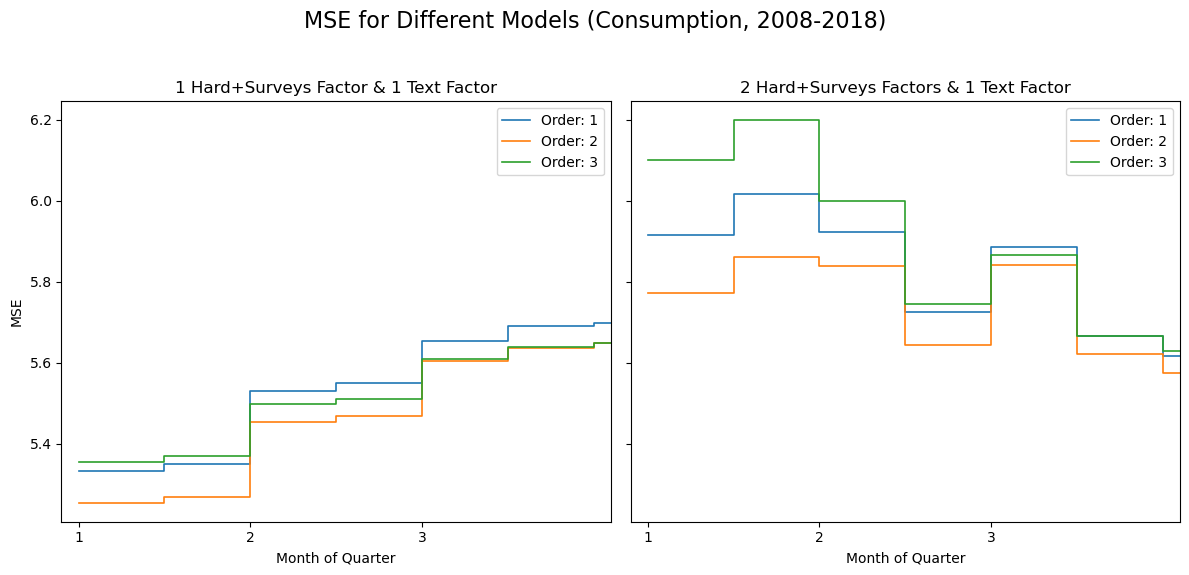

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Consumption'
text_type = "topics_uncertainty"
estimation_period = "2007"
num_topics = "200"
source = "all"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update"

# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Loop over the number of HardSurveys factors (1 or 2)
for i, num_factors in enumerate(range(1, 3)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"HS_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


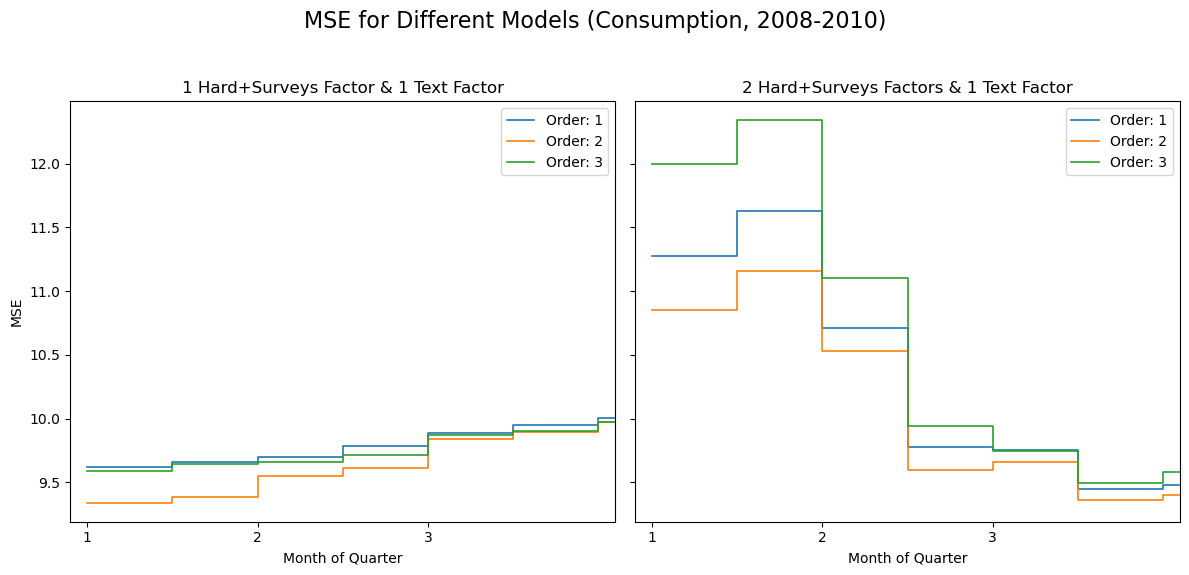

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


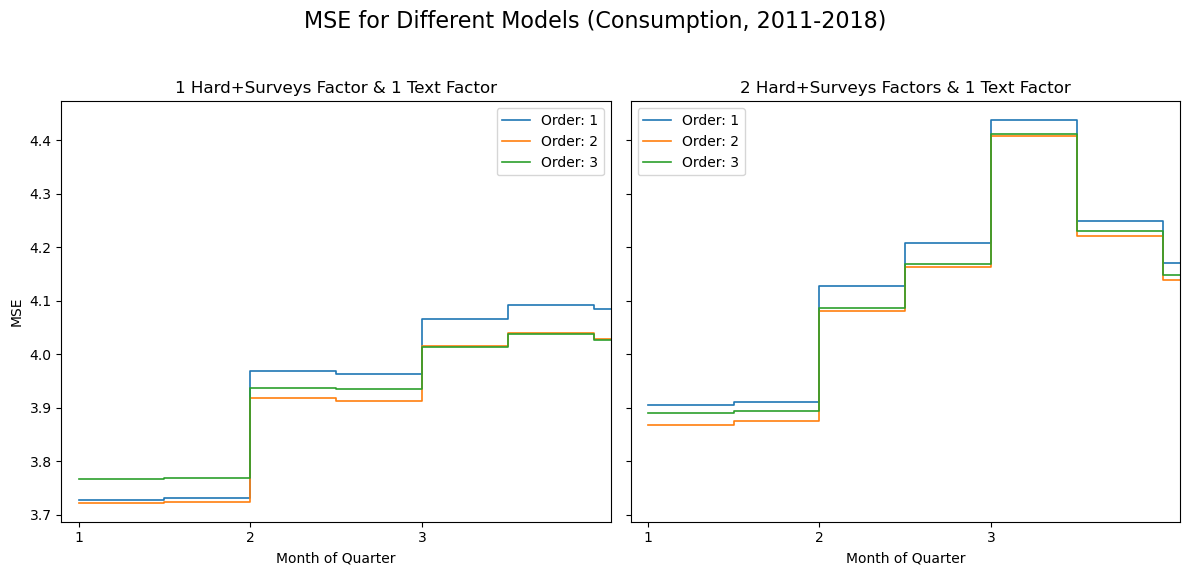

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics_uncertainty"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update"
actual_growth_file = f"../{q_var}_growth_actual_update.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 2 columns of subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate(range(1, 3)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_Consumption_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


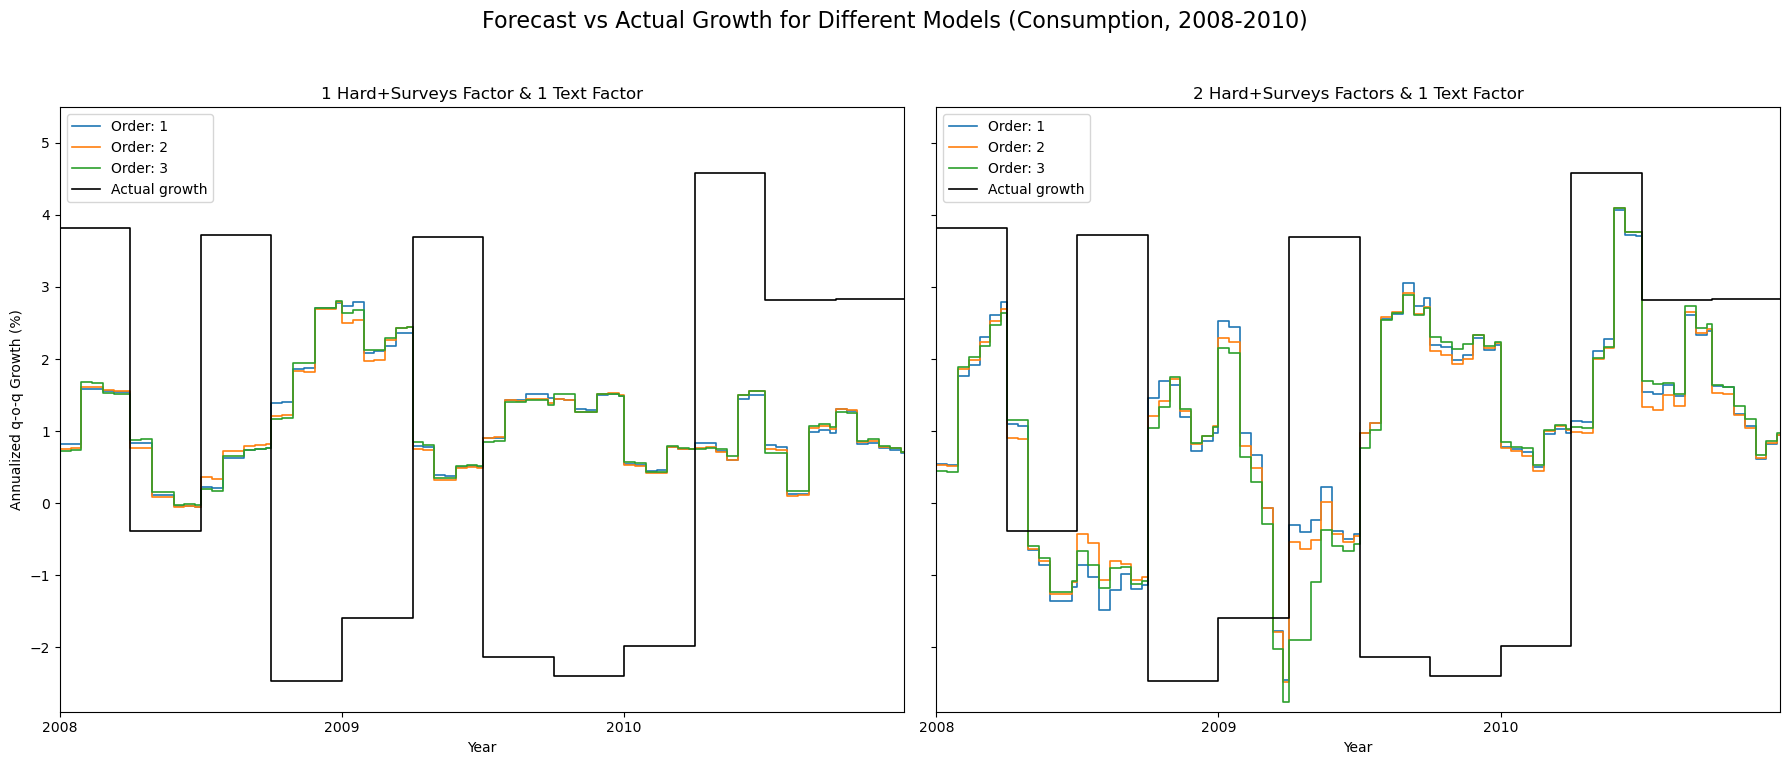

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


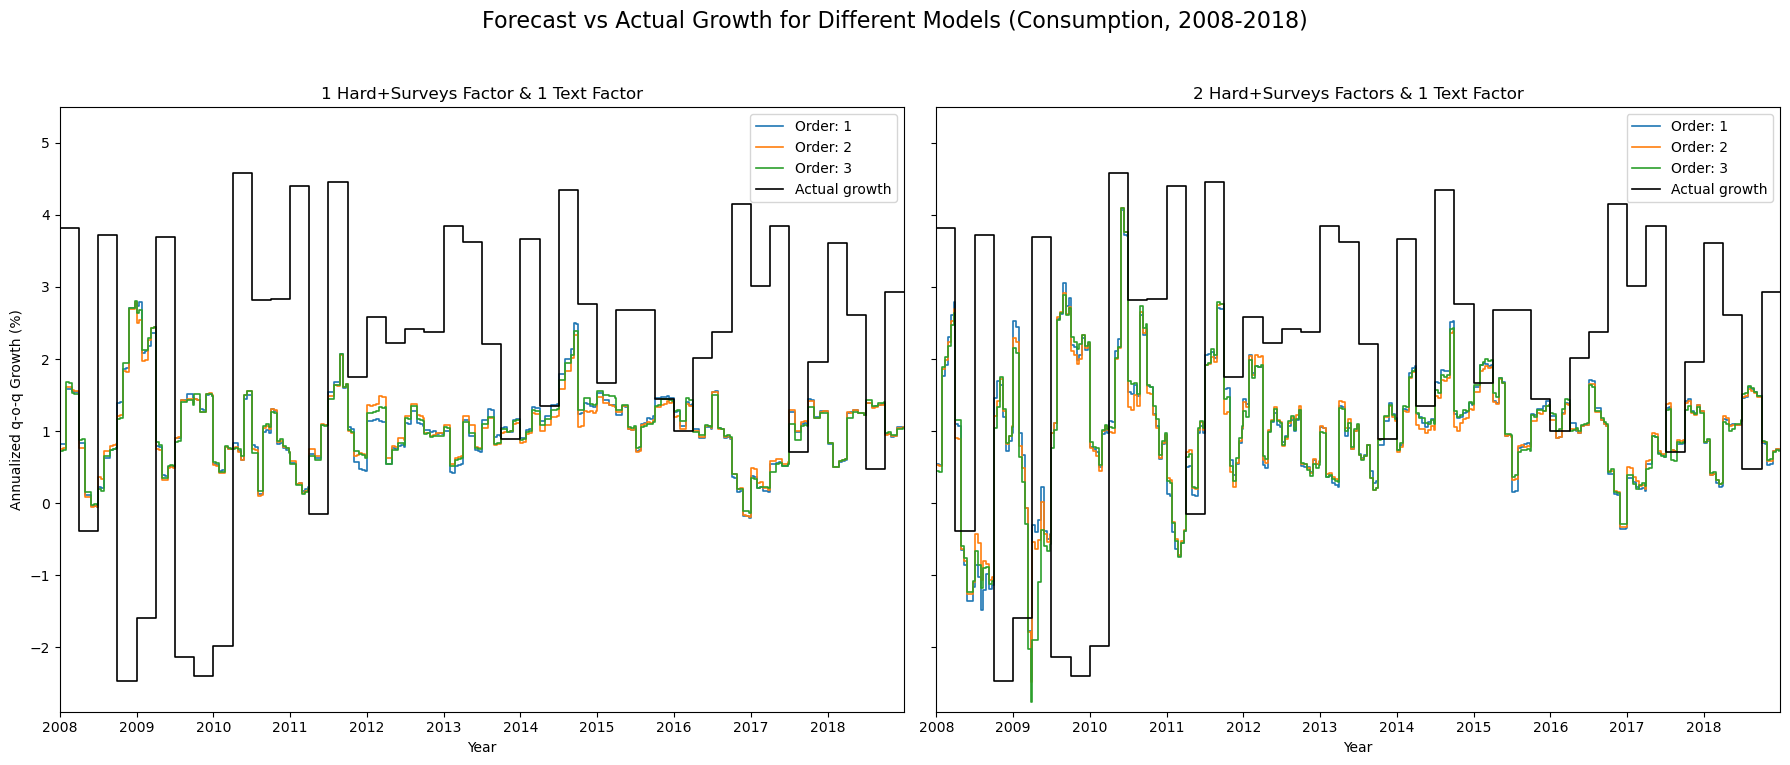

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


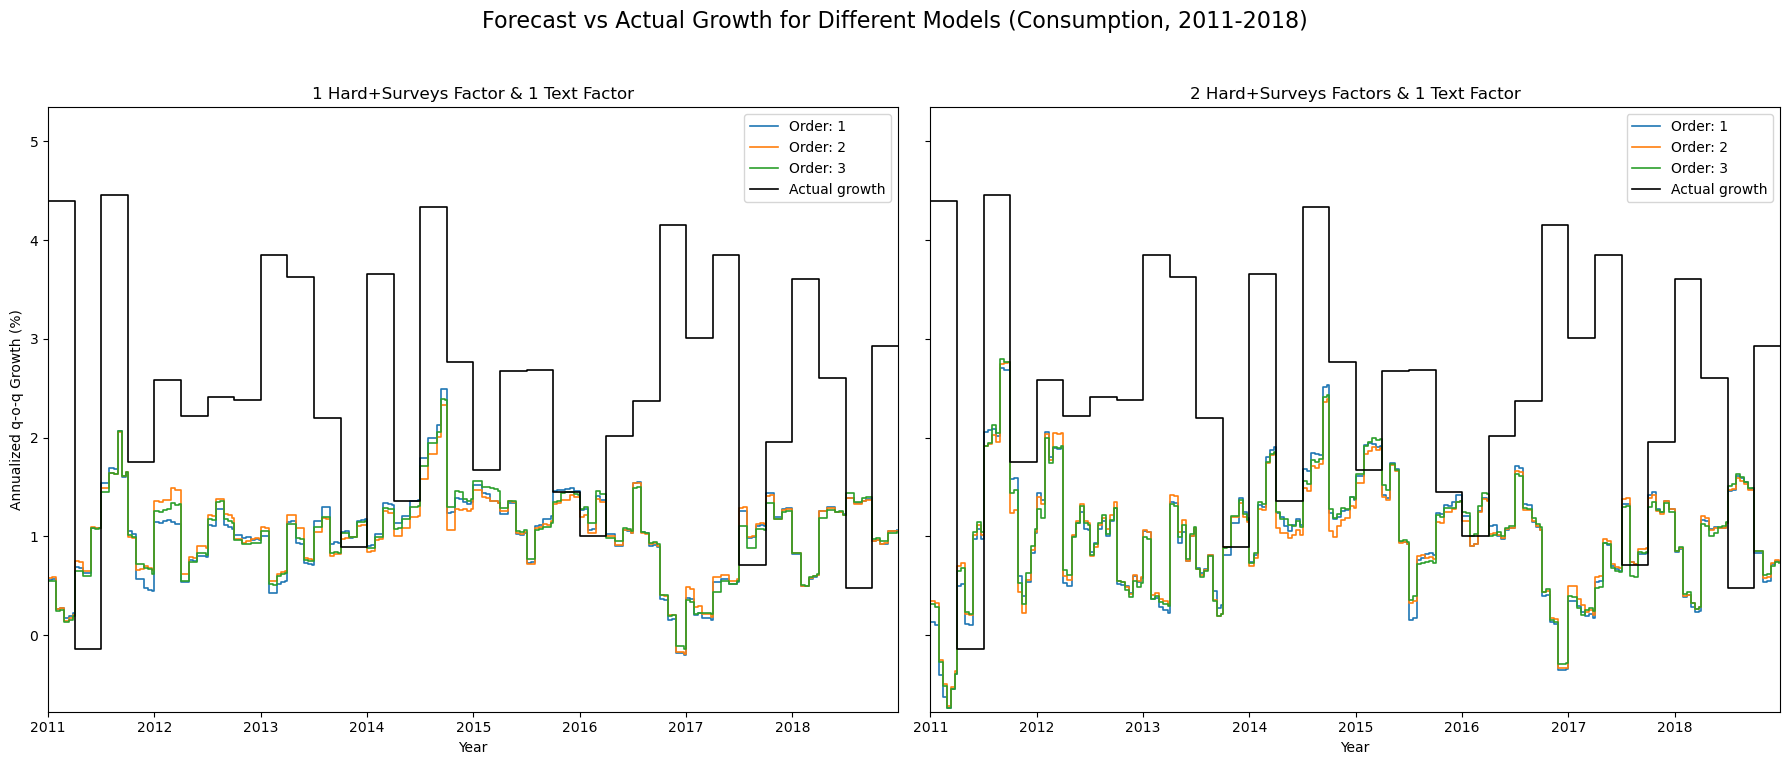

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics_uncertainty"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update"
actual_growth_file = f"../{q_var}_growth_actual_update.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 2 columns for the two Hard+Surveys factor counts
    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate([1, 2]):
        ax = axs[i]

        # For each HardSurveys factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_Consumption_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()